# PyTorch NN Classification

## 1. Make classification data and get it ready - Toy Data

In [1]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd


In [2]:
n_samples = 1000
X,y = make_circles(n_samples, noise=0.03,
                   random_state=42)
print(len(X), len(y))
X[:5], y[:5]

1000 1000


(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


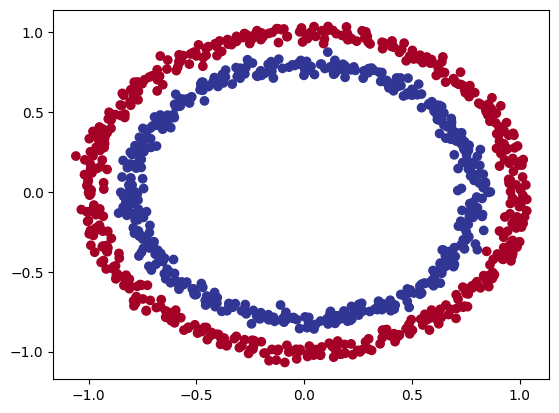

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y =X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Checking input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X_sample = X[0]
y_sample = y[0]
print(X_sample, y_sample)

[0.75424625 0.23148074] 1


### 1.2 Turn data to tensors and create train and test splits

In [7]:
import torch
torch.__version__

'2.5.1+cu121'

In [8]:
X.dtype

dtype('float64')

In [9]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Building a model

1. Setup device agnostic code
2. Construct a model by subclassing nn.Module
3. Define a loss function and optimizer

### 2.1 Setup device agnostic code

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2.2 Create a model by:-

- Subclass `nn.Module`
- Create 2 `nn.Linear()` layers that are capable of handling shapes of our data
- Defines a `forward()` method that outlines the forward pass of the model
- Instatiate an instance of our model class and send it to the target device

In [12]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer_1 = nn.Linear(in_features=2,
        #                          out_features=5)
        # self.layer_2 = nn.Linear(in_features=5,
        #                          out_features=1)
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )

    def forward(self,x):
        return self.two_linear_layers(x)

model_0 = CircleModel().to(device)
model_0

CircleModel(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [13]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [14]:
# lets replicate the above model using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6221, -0.0267],
                      [ 0.4783, -0.0897],
                      [-0.3370,  0.3482],
                      [-0.3656,  0.2848],
                      [-0.0736,  0.5046]], device='cuda:0')),
             ('0.bias',
              tensor([0.6225, 0.3180, 0.1173, 0.5880, 0.6994], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1665, -0.2049, -0.3699, -0.4218,  0.3680]], device='cuda:0')),
             ('1.bias', tensor([0.0958], device='cuda:0'))])

In [16]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(len(untrained_preds), untrained_preds.shape)
    print(len(X_test), X_test.shape)
    print(untrained_preds[:10])
    print(y_test[:10])

200 torch.Size([200, 1])
200 torch.Size([200, 2])
tensor([[-0.0299],
        [ 0.0569],
        [-0.0651],
        [-0.0208],
        [ 0.2406],
        [ 0.2912],
        [ 0.2935],
        [ 0.3492],
        [-0.0779],
        [ 0.0661]], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.3 Loss function and Optimizer declaration

In [17]:
loss_fn = nn.BCEWithLogitsLoss() # combines both sigmoid and nn.BCELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Build a Training Loop and Testing Loop

**Training Loop:**

- Forward pass
- Loss computation
- Zero the optimizer gradients
- Backpropagate the loss
- Optimizer step

### 3.1 Going from raw logits -> prediction probs -> prediction labels

Our model outputs are going to be raw logits and we convert these logits in to prediction probabilities by passing them to some kind of activation function depending on the problem. Then we convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [19]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
print(y_logits)


tensor([[-0.0299],
        [ 0.0569],
        [-0.0651],
        [-0.0208],
        [ 0.2406]], device='cuda:0')


In [20]:
# use sigmoids to convert them to prediction probs
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)
print(torch.round(y_pred_probs))
#print(y_preds)
print(y_test[:5])

y_preds = torch.round(y_pred_probs)
# now lets do it in full
model_0.eval()
with torch.inference_mode():
    # logits -> prediction probs -> prediction labels
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

## check for equality

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([[0.4925],
        [0.5142],
        [0.4837],
        [0.4948],
        [0.5598]], device='cuda:0')
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cuda:0')
tensor([1., 0., 1., 0., 1.])
tensor([True, True, True, True, True], device='cuda:0')


In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Build a training loop

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    # logits -> prediction probs -> labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    # nn.BCEWithLogitsLoss() takes logits as input
    loss = loss_fn(
        y_logits, y_train
    )
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. zero the optimizer gradients
    optimizer.zero_grad()

    # 4. Backpropagate the loss
    loss.backward()

    # 5. Step the optimizer grads (gradient descent)
    optimizer.step()

    # TEsting Loop
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(
            y_true=y_test,
            y_pred = test_pred
        )

    # print what's happening
    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69763 | Acc: 51.75% | Test Loss: 0.69902, Test Acc: 52.00%
Epoch: 10 | Loss: 0.69572 | Acc: 50.88% | Test Loss: 0.69712, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69483 | Acc: 50.50% | Test Loss: 0.69624, Test Acc: 51.00%
Epoch: 30 | Loss: 0.69429 | Acc: 49.75% | Test Loss: 0.69574, Test Acc: 52.50%
Epoch: 40 | Loss: 0.69393 | Acc: 49.88% | Test Loss: 0.69542, Test Acc: 50.50%
Epoch: 50 | Loss: 0.69367 | Acc: 50.12% | Test Loss: 0.69520, Test Acc: 49.50%
Epoch: 60 | Loss: 0.69348 | Acc: 50.25% | Test Loss: 0.69505, Test Acc: 49.50%
Epoch: 70 | Loss: 0.69335 | Acc: 50.25% | Test Loss: 0.69494, Test Acc: 48.00%
Epoch: 80 | Loss: 0.69325 | Acc: 50.62% | Test Loss: 0.69486, Test Acc: 49.00%
Epoch: 90 | Loss: 0.69318 | Acc: 50.50% | Test Loss: 0.69481, Test Acc: 49.50%


## 3.3 Make prediction and visualize

TO do this we use an helper function called `plot_decision_boundary()` that we import from github : https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [23]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("The file already exists, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions

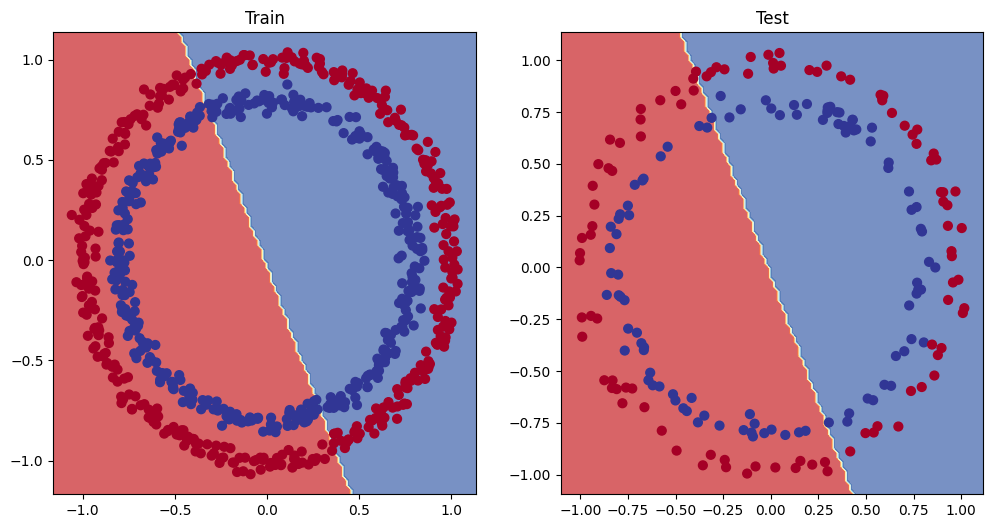

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 4. Improving the Model from Model's perspective

- Since the model built by us is only linear it is unable to classify the
circular data
- T overcome this we can add activation layers and increase the number of layers and units in each layer
- We can also adjust learning rate and loss function too


In [25]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6088, -0.0198],
                      [ 0.5075, -0.1049],
                      [-0.2961,  0.3269],
                      [-0.3170,  0.2594],
                      [-0.1175,  0.5276]])),
             ('0.bias', tensor([0.6174, 0.3262, 0.1304, 0.6033, 0.6860])),
             ('1.weight',
              tensor([[ 0.0693, -0.2812, -0.3158, -0.3861,  0.3860]])),
             ('1.bias', tensor([0.0592]))])

In [26]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # this way of writing improves the operations speed
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1.state_dict()


OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [27]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# optimizer

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [28]:
# Create training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000
for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimize the zero grad
    optimizer.zero_grad()

    # 4. Backpropagate the loss
    loss.backward()

    # 5. Step the gradients
    optimizer.step()

    ## TEsting Loop
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch%100==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.69396 | Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00% 
Epoch: 100 | Loss: 0.69305 | Accuracy: 50.38% | Test Loss: 0.69379 | Test Accuracy: 48.00% 
Epoch: 200 | Loss: 0.69299 | Accuracy: 51.12% | Test Loss: 0.69437 | Test Accuracy: 46.00% 
Epoch: 300 | Loss: 0.69298 | Accuracy: 51.62% | Test Loss: 0.69458 | Test Accuracy: 45.00% 
Epoch: 400 | Loss: 0.69298 | Accuracy: 51.12% | Test Loss: 0.69465 | Test Accuracy: 46.00% 
Epoch: 500 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69467 | Test Accuracy: 46.00% 
Epoch: 600 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00% 
Epoch: 700 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00% 
Epoch: 800 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00% 
Epoch: 900 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69468 | Test Accuracy: 46.00% 


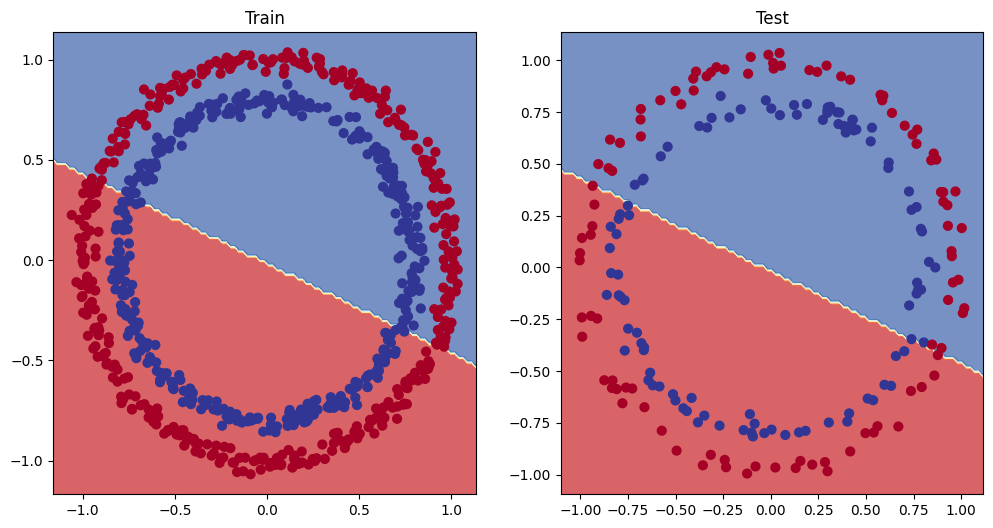

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5. Preparing data to see if our model can fit a st. line

In [30]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01
X_regression  = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias
X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [31]:

train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression)

(80, 20)

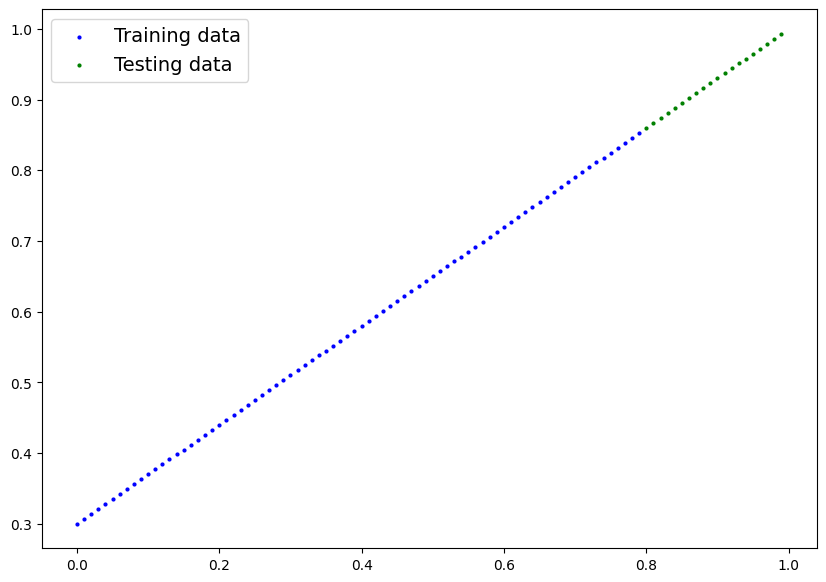

In [32]:
plot_predictions(train_data =X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels=y_test_regression,
                 )

### 5.1 Modify the model_1's in_features to 1

In [33]:
# create new model

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
loss_fn =nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)


In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)


for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss= loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch%100==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


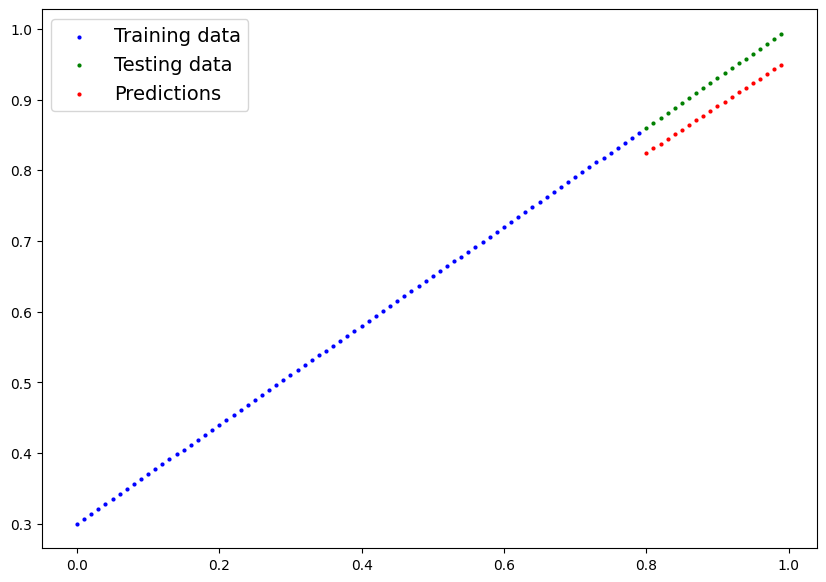

In [36]:
model_2.eval()
with torch.inference_mode():
    y_test_pred = model_2(X_test_regression)

plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels = y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels = y_test_regression.cpu(),
    predictions=y_test_pred.cpu()

)

## 6. Missing Piece - Non-Linearity

Our model misses non-linearity and this is the reason it is unable to come up with proper decision boundaries

### 6.1 Recreating non-linear data

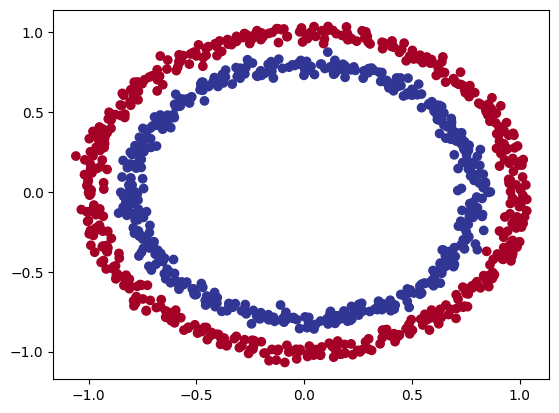

In [37]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples=n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [38]:
# convert data to tensors and then to train and test splits

import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
from torch import nn

class CircleModelV2(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):

        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [41]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.2)

### 6.3 Building a training loop

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred = test_pred)

    if epoch%100==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.69295 | Accuracy: 50.00% | Test Loss: 0.69312 | Test Accuracy: 50.00% 
Epoch: 100 | Loss: 0.68978 | Accuracy: 53.37% | Test Loss: 0.68938 | Test Accuracy: 55.50% 
Epoch: 200 | Loss: 0.68518 | Accuracy: 52.75% | Test Loss: 0.68409 | Test Accuracy: 56.50% 
Epoch: 300 | Loss: 0.67520 | Accuracy: 54.37% | Test Loss: 0.67282 | Test Accuracy: 56.50% 
Epoch: 400 | Loss: 0.65179 | Accuracy: 63.88% | Test Loss: 0.64756 | Test Accuracy: 67.50% 
Epoch: 500 | Loss: 0.56917 | Accuracy: 87.50% | Test Loss: 0.57400 | Test Accuracy: 86.50% 
Epoch: 600 | Loss: 0.37245 | Accuracy: 97.88% | Test Loss: 0.40668 | Test Accuracy: 92.50% 
Epoch: 700 | Loss: 0.30881 | Accuracy: 87.12% | Test Loss: 0.34613 | Test Accuracy: 81.50% 
Epoch: 800 | Loss: 0.09464 | Accuracy: 99.88% | Test Loss: 0.13391 | Test Accuracy: 99.50% 
Epoch: 900 | Loss: 0.05634 | Accuracy: 99.88% | Test Loss: 0.08544 | Test Accuracy: 99.50% 


### 6.4 Evaluating a model trained with non-linear activation functions

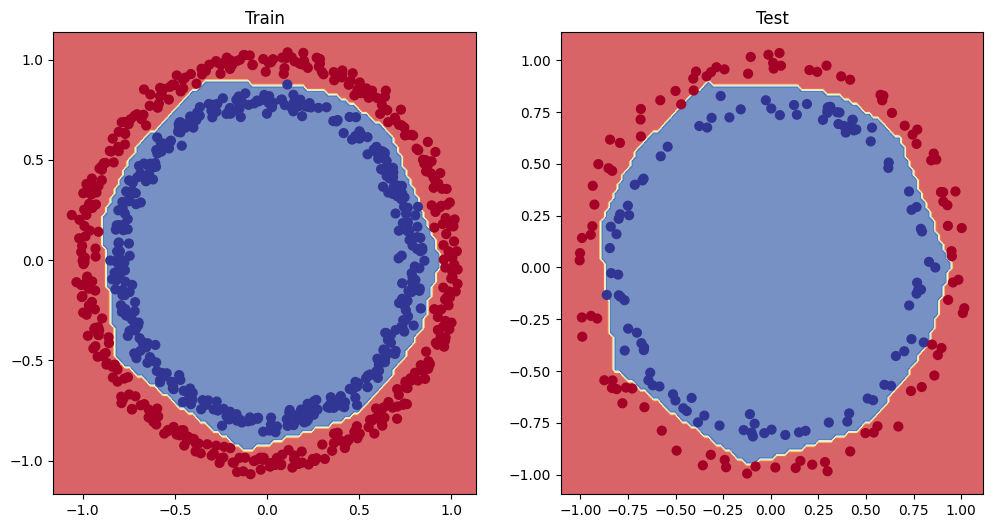

In [43]:
model_3.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [44]:
A = torch.arange(-10,10,1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

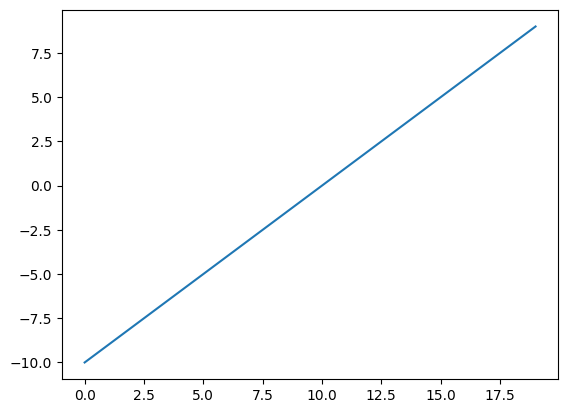

In [45]:
plt.plot(A)

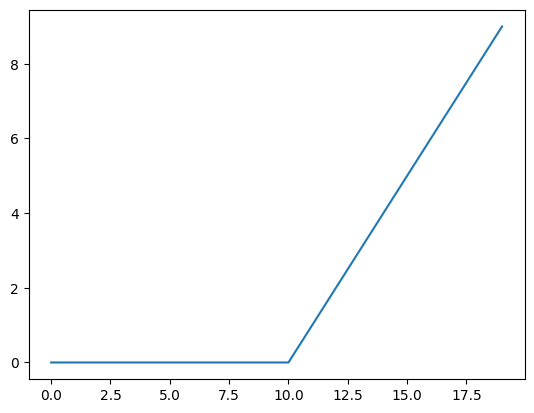

In [46]:
plt.plot(torch.relu(A))

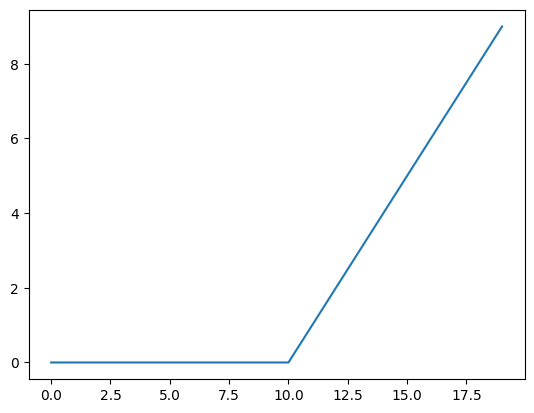

In [47]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)
plt.plot(relu(A))

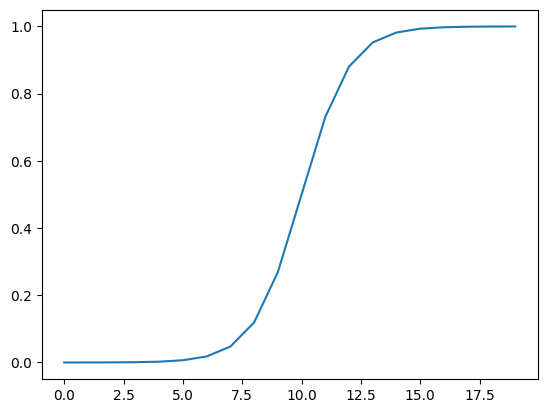

In [48]:
plt.plot(torch.sigmoid(A))

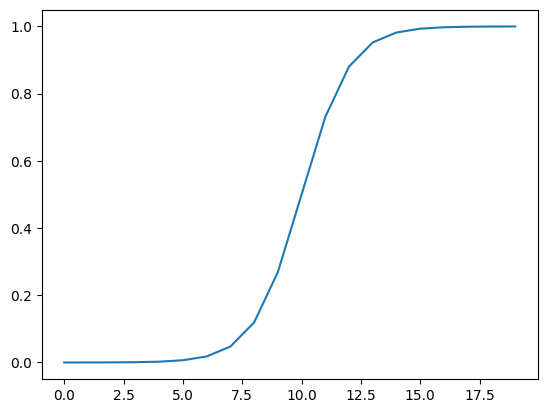

In [49]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

plt.plot(sigmoid(A))

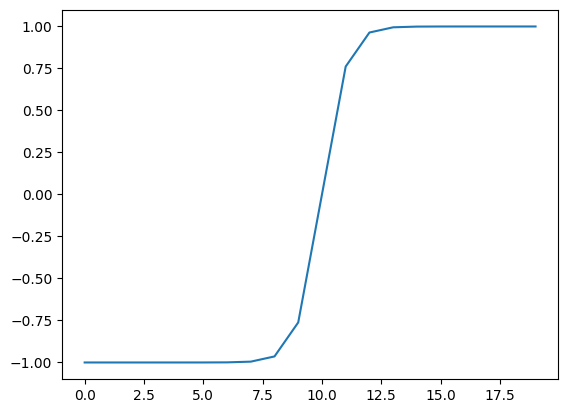

In [50]:
plt.plot(torch.tanh(A))

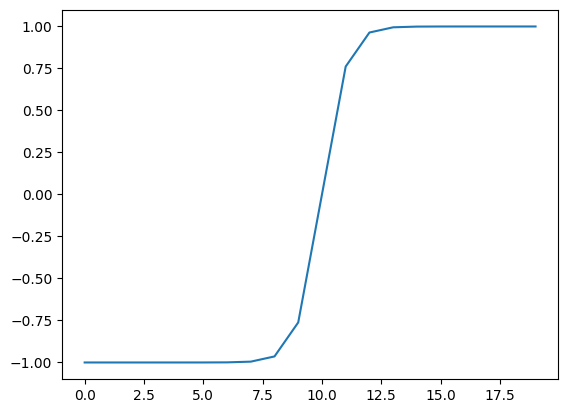

In [51]:
def tanh(x):
    return (torch.exp(A)-torch.exp(-A))/(torch.exp(A)+torch.exp(-A))

plt.plot(tanh(A))

## 8. Multiclass Classification Problem

### 8.1 Creating a toy multi-class dataset

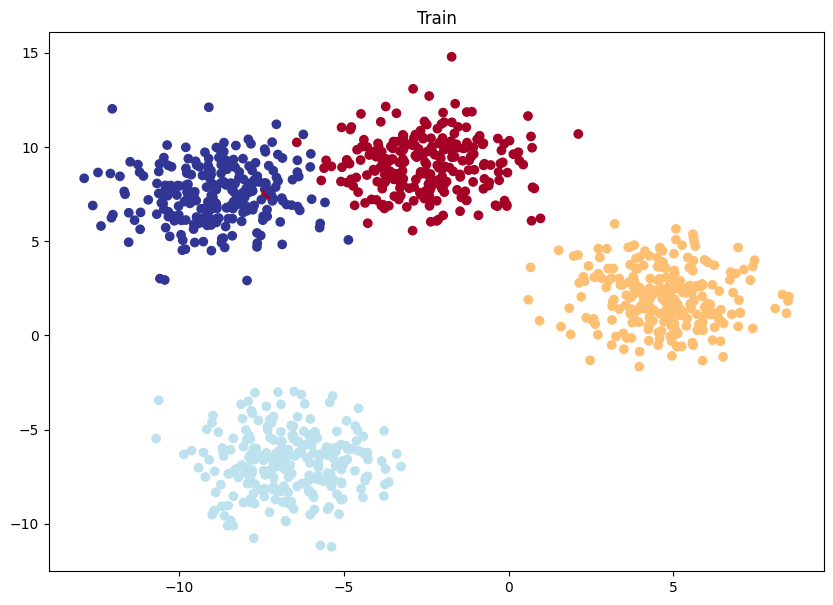

In [52]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES=4
NUM_FEATURES = 2
RANDOM_SEED=42

# 1. Create multiclass data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.title("Train")
plt.scatter(X_blob[:,0], X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [54]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features=4, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(2,4,8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Loss function is Cross Entropy Loss

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probs for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's output to prediction probs to prediction labels

logits(raw output) -> pred probs(`torch.softmax`) -> pred labels(take argmax of pred probs)

In [56]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')

In [57]:
# get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0')
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0')


In [58]:
# convert our model's probs to labels
y_pred_labels = torch.argmax(y_pred_probs,dim=1)
print(y_pred_labels)
print(y_blob_test)

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3], device='cuda:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1,

### 8.5 Create a Training loop

In [59]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)



for epoch in range(epochs):

    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_preds)

    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")


Epoch: 0 | Loss: 1.0432, Acc: 65.50% | Test Loss: 0.5786, Test Accuracy: 95.50
Epoch: 10 | Loss: 0.1440, Acc: 99.12% | Test Loss: 0.1304, Test Accuracy: 99.00
Epoch: 20 | Loss: 0.0806, Acc: 99.12% | Test Loss: 0.0722, Test Accuracy: 99.50
Epoch: 30 | Loss: 0.0592, Acc: 99.12% | Test Loss: 0.0513, Test Accuracy: 99.50
Epoch: 40 | Loss: 0.0489, Acc: 99.00% | Test Loss: 0.0410, Test Accuracy: 99.50
Epoch: 50 | Loss: 0.0429, Acc: 99.00% | Test Loss: 0.0349, Test Accuracy: 99.50
Epoch: 60 | Loss: 0.0391, Acc: 99.00% | Test Loss: 0.0308, Test Accuracy: 99.50
Epoch: 70 | Loss: 0.0364, Acc: 99.00% | Test Loss: 0.0280, Test Accuracy: 99.50
Epoch: 80 | Loss: 0.0345, Acc: 99.00% | Test Loss: 0.0259, Test Accuracy: 99.50
Epoch: 90 | Loss: 0.0330, Acc: 99.12% | Test Loss: 0.0242, Test Accuracy: 99.50


### 8.6 Making and evaluating predictions

In [60]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [61]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [62]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

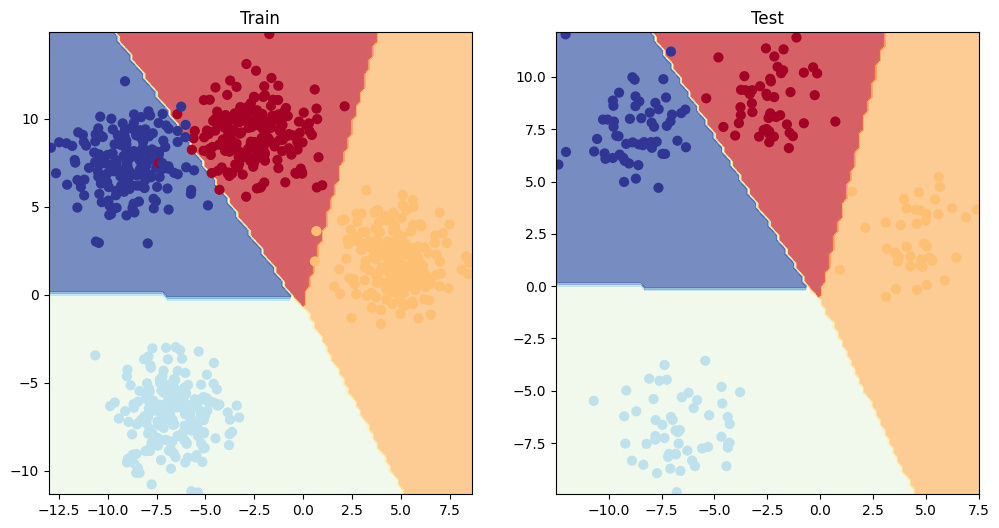

In [63]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. Classification Metrics

- Accuracy
- Precision
- Recall
- F1-score
- Confusion Matrix
Use [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html) for in built metrics calculation

In [64]:
import torchmetrics

acc = torchmetrics.functional.accuracy(y_preds, y_blob_test,task='multiclass', num_classes=4)
acc

tensor(0.9950, device='cuda:0')